# Gross-Vitells LEE toy example

For an more detailed description of using this method in the context of a bump hunt,  [see this notebook]()

In [1]:
# imports and configuration

%cd '/home/naodell/work/nllfit'
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import legval
from scipy.stats import norm, chi2
from tqdm import tqdm_notebook

from nllfit import Parameters, ScanParameters, Model, NLLFitter
import nllfit.fit_tools as ft
import nllfit.lookee as lee


/home/naodell/work/nllfit


Now we're ready to carry out the scans.  For each toy dataset, we will save the parameters that minimize the nll, the value of the EC for several excursion thresholds `u_0`.  I should mention that I used [Kyle Cranmer's notebook](https://github.com/cranmer/look-elsewhere-2d) on GV as a starting point.  For the most part, my framework is completely independent, but I did take his [code for calculating the EC](https://github.com/cranmer/look-elsewhere-2d).  It makes very nice use of numpy's image convolution modules.

In [ ]:
bg_fitter.verbose = False # turn off parameter printing
phiscan   = []
qmaxscan  = []
u_0       = np.linspace(0.01, 30., 300)
for i, sim in tqdm_notebook(enumerate(sims), 
                            desc='Scanning', 
                            unit_scale=True, 
                            ncols=75, 
                            total=len(sims)):
    # fit background model
    bg_result = bg_fitter.fit(sim, calculate_corr=False)
    if bg_result.status == 0:
        nll_bg = bg_model.calc_nll(sim)
    else:
        continue
        

    # scan over signal parameters
    nllscan, params, dof = sig_fitter.scan(scan_params, sim)
    qscan = -2*(nllscan - nll_bg)
    qmaxscan.append(np.max(qscan))

    ### Calculate E.C. of the random field
    if qscan.size != np.prod(scan_params.nscans):
        continue
        
    qscan = np.array(qscan).reshape(scan_params.nscans)
    phiscan.append([lee.calculate_euler_characteristic((qscan > u) + 0.) 
                    for u in u_0])

# convert lists to arrays
phiscan     = np.array(phiscan)
qmaxscan    = np.array(qmaxscan)

Having completed the scans and calculated the corresponding EC, the coefficients for the EC densities can be determined.  This is done by carrying out a fit to the scan data.

In [10]:
param_init = [1.,1.]
param_bnds = [(0., np.inf), (0., np.inf)]
kvals      = [1]
scales     = [0.5]
nvals      = lee.get_GV_coefficients(u_0, phiscan, param_init, param_bnds, kvals, scales)

Finally, calculate the relevant statistics and print the results,

In [13]:
### Calculate statistics and print ###
p_local  = 0.5*chi2.sf(qmax, 1)
z_local  = -norm.ppf(p_local)
p_global = lee.get_p_global(qmax, [1], [nvals], [0.5])
z_global = -norm.ppf(p_global)

for i, n in enumerate(nvals.flatten()):
    print 'N{0} = {1:.2f}'.format(i+1, n)

print 'local p value       = {0:.3e}'.format(p_local)
print 'local significance  = {0:.2f}'.format(z_local)
print 'global p value      = {0:.3e}'.format(p_global)
print 'global significance = {0:.2f}'.format(z_global)
print 'trial factor        = {0:.2f}'.format(p_global/p_local)


N1 = 0.00
N2 = 151.75
local p value       = 2.216e-09
local significance  = 5.87
global p value      = 1.895e-06
global significance = 4.62
trial factor        = 855.33


For the sake of validating this result we can check if our prediction from the Gross-Vitells formalism compares well with the distribution from the toy data.

nllfit/lookee.py:179: RuntimeWarning: invalid value encountered in true_divide
  perr = pval*(herr/hval)


<IPython.core.display.Javascript object>


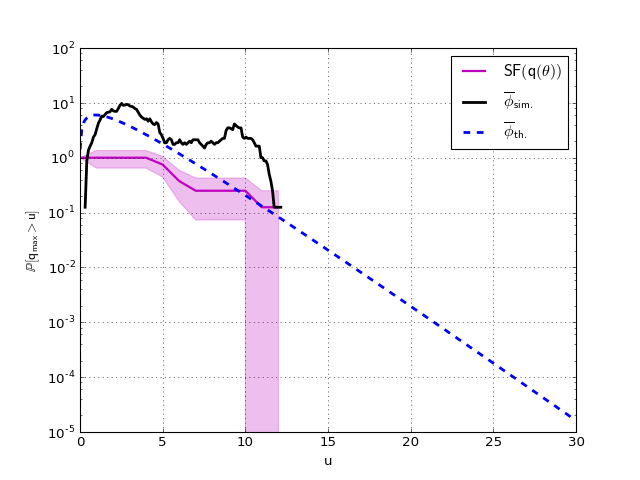

In [12]:
lee.gv_validation_plot(u_0, phiscan, qmaxscan, [nvals], [1], [0.5], None)